# Esempio di funzionamento di HARP
https://github.com/GTmac/HARP/tree/master/src

In [2]:
import sparker
import pandas as pd
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt
import graph_coarsening
import magicgraph
import tqdm
from multiprocessing.pool import ThreadPool
from sklearn.metrics.pairwise import cosine_similarity
%load_ext autotime

time: 204 µs (started: 2021-12-07 13:56:11 +00:00)


In [3]:
#Visualizza i dati di un profilo
def printProfile(p):
    print("Profile ID "+str(p.profileID))
    print("Original ID "+str(p.originalID))
    
    for kv in p.attributes:
        print(kv.key+": "+kv.value)
    pass

#Visualizza i dati di un profilo dato l'id
def showProfile(pid):
    global profiles
    p = profiles.filter(lambda x: x.profileID == pid).collect()
    if len(p) > 0:
        printProfile(p[0])
    else:
        print("Not found")
    pass

def get_prog_rec(method, n, gt):
    prog_rec = []
    for i in range(0, n):
        cmp = method.get_next()
        if (cmp[1], cmp[2]) in gt:
            prog_rec.append(1)
        else:
            prog_rec.append(0)
    prog_rec = np.cumsum(prog_rec)/len(gt)
    
    return prog_rec

time: 759 µs (started: 2021-12-07 13:56:11 +00:00)


## Carico i profili
Utilizzando SparkER carico i profili

In [4]:
dataset = "datasets/movies"

profiles1 = sparker.JSONWrapper.load_profiles('/data2/luca/ER/'+dataset+'/dataset1.json', 
                                              real_id_field = "realProfileID",
                                              source_id=1)
separator_id = profiles1.map(lambda profile: profile.profile_id).max()
separator_ids = [separator_id]

profiles2 = sparker.JSONWrapper.load_profiles('/data2/luca/ER/'+dataset+'/dataset2.json', 
                                              start_id_from = separator_id+1, 
                                              real_id_field = "realProfileID",
                                              source_id=2)
max_profile_id = profiles2.map(lambda profile: profile.profile_id).max()
profiles = profiles1.union(profiles2)

time: 2.74 s (started: 2021-12-07 13:56:11 +00:00)


In [5]:
gt = sparker.JSONWrapper.load_groundtruth('/data2/luca/ER/'+dataset+'/groundtruth.json', 'id1', 'id2')
new_gt = sparker.Converters.convert_groundtruth(gt, profiles1, profiles2)

time: 752 ms (started: 2021-12-07 13:56:14 +00:00)


## Applico il token blocking per generare i blocchi iniziali

In [6]:
clusters = sparker.AttributeClustering.cluster_similar_attributes(profiles, 256, 0.2, compute_entropy=True)

time: 1min 6s (started: 2021-12-07 13:56:15 +00:00)


In [7]:
for c in clusters:
    print(c.keys)

['2_director name', '1_writer']
['2_actor name', '1_starring']
['1_title', '2_title']
['2_genre', '2_url', '2_imdb_ksearch_id', '1_editor', '2_year']
time: 611 µs (started: 2021-12-07 13:57:21 +00:00)


In [8]:
blocks = sparker.Blocking.create_blocks_clusters(profiles, clusters, separator_ids)

time: 2.77 s (started: 2021-12-07 13:57:21 +00:00)


## Eseguo purging e filtering per rimuovere edge superflui

In [9]:
# Perfoms the purging
blocks_purged = sparker.BlockPurging.block_purging(blocks, 1.025)
# Performs the cleaning
(profile_blocks, profile_blocks_filtered, blocks_after_filtering) = sparker.BlockFiltering.block_filtering_quick(blocks_purged, 0.8, separator_ids)

time: 916 ms (started: 2021-12-07 13:57:24 +00:00)


## Applico il meta-blocking per ottenere gli edge rilevanti

In [10]:
block_index_map = blocks_after_filtering.map(lambda b : (b.block_id, b.profiles)).collectAsMap()
block_index = sc.broadcast(block_index_map)

profileBlocksSizeIndex = sc.broadcast(profile_blocks_filtered.map(lambda pb : (pb.profile_id, len(pb.blocks))).collectAsMap())
entropiesMap = blocks.map(lambda b : (b.block_id, b.entropy)).collectAsMap()
entropies = sc.broadcast(entropiesMap)

time: 3.95 s (started: 2021-12-07 13:57:25 +00:00)


In [11]:
results = sparker.WNP.wnp(
                          profile_blocks_filtered,
                          block_index,
                          max_profile_id,
                          separator_ids,
                          weight_type=sparker.WeightTypes.CHI_SQUARE,
                          groundtruth=None,
                          profile_blocks_size_index=profileBlocksSizeIndex,
                          threshold_type=sparker.ThresholdTypes.MAX_FRACT_2,
                          use_entropy=True,
                          blocks_entropies=entropies,
                          chi2divider=4.0
                         )

#Alternativa che si può usare per ottenere gli edge pesati SENZA applicare il metablocking
"""
results = sparker.WNP.get_all_edges(
                          profileBlocksFiltered,
                          blockIndex,
                          maxProfileID,
                          separatorIDs,
                          sparker.WeightTypes.JS,
                          profileBlocksSizeIndex
                         )
"""

#Raccolgo tutti gli edge
edges = results.flatMap(lambda x: x[2]).collect()

time: 3min 25s (started: 2021-12-07 13:57:29 +00:00)


In [12]:
#Calcolo la recall alla fine del meta-blocking
nm = 0
for e in edges:
    if (e[0], e[1]) in new_gt:
        nm += 1

prec = nm / len(edges)       
rec = nm / len(new_gt)
print("Recall",rec)
print("Precision",prec)

Recall 0.9405589817609238
Precision 0.23032925601422422
time: 29.7 ms (started: 2021-12-07 14:00:55 +00:00)


## Utilizzo gli edge pesati del meta-blocking per creare un grafo e generare gli embeddings

In [13]:
class embedder:
    def __init__(self, emb_size, max_profile_id, gt, sep=-1):
        """
            emb_size -> dimensione embedding
            max_profile_id -> id massimo esistente tra i profili
            gt -> groundtruth
            sep -> separatore tra profili (solo se clean-clean)
        """
        self.sep = sep
        self.emb_size = emb_size
        self.max_profile_id = max_profile_id
        self.gt = gt
        pass
    
    def get_embeddings(self):
        return self.embeddings_mat
    
    def get_emb2profile(self):
        return self.emb2profile
    
    
    def fit(self, edges, weighted=True, undirected=True):
        """
            Genera gli embeddings forniti gli edge ottenuti dal meta-blocking
        """
        
        #Creo il grafo
        self.G = magicgraph.from_edges(edges, weighted=weighted, undirected=undirected)
        self.G = graph_coarsening.DoubleWeightedDiGraph(self.G)
        #Genero gli embeddings
        sfdp_path = "./"
        number_walks = 40
        walk_length = 10
        representation_size = self.emb_size
        window_size = 2
        #Questo è un dictionary che contiene come chiave l'id del nodo
        #Un nodo, se non compare negli edge, può non essere embeddato.
        self.embeddings = graph_coarsening.skipgram_coarsening_disconnected(self.G, scale=-1, iter_count=1,
                sfdp_path=sfdp_path,
                num_paths=number_walks,
                path_length=walk_length,
                representation_size=representation_size,
                window_size=window_size,
                lr_scheme='default',
                alpha=0.025,min_alpha=0.001,sg=1,hs=0,coarsening_scheme=2, sample=0.1)
        
        #Inizializzo la matrice degli embeddings, dimensione max x max
        self.embeddings_mat = np.zeros(shape=(self.max_profile_id+1, self.emb_size))
        #Profili per cui non esiste un embedding
        self.not_found = []

        #Inizializzo gli indici e creo la matrice
        for p in range(0, self.max_profile_id+1):
            #Se per il profilo è stato calcolato un embeddings lo aggiungo alla matrice
            if p in self.embeddings:
                self.embeddings_mat[p] = self.embeddings[p]
            else:
                self.not_found.append(p)

                
        #Calcolo la similarità tra i profili, crea una matrice simmetrica di dimensioni max_profile_id+1 
        #x max_profile_id+1
        self.sim = (cosine_similarity(self.embeddings_mat)+1)/2
        #Annullo le similarità dei profili con se stessi
        np.fill_diagonal(self.sim, 0)
        #Siccome la matrice è simmetrica tengo solo il triangolo superiore
        self.sim = np.triu(self.sim)

        #Annullo le similarità di tutti i vettori per cui non esiste l'embedding
        for p in self.not_found:
            self.sim[: , p] = 0
            self.sim[p, :] = 0

        #Se è clean-clean annullo tutte le similarità tra elementi dello stesso dataset
        if self.sep >= 0:
            self.sim = self.sim[0:self.sep+1, :]
            for p in range(0, len(self.sim)):
                self.sim[p, 0:self.sep+1] = 0
    
    
    def get_top_k(self, p, k):
        """
            Dato l'id di un profilo
            ritorna i suoi k vicini più simili usando gli embeddings.
            Usa la cosine similarity per calcolare la similarità.
            p -> id del profilo
            k -> numero di vicini che si vogliono ottenere
        """
        #Preno la cosine del profilo con tutti gli altri embeddings
        top_k = np.argpartition(self.sim[p], -k)[-k:]
        #Argpartition mi dà i top-k non ordinati
        #Quindi ordino per similarità ritornando le triple (p1, p2, sim_p1_p2)
        #Per come ho costruito sim sono sicuro che p1 < p2
        #Ritorno solo le similarità valide, cioè > 0
        return sorted([(n, self.sim[p][n]) for n in top_k if self.sim[p][n] > 0], key=lambda x: -x[1])
    
    def calc_progressive_recall(self, k):
        """
            Calcola la recall progressiva dato k.
            Partendo da k_int=1 fino a k_int=k
            per ogni profilo prende i top-k_int profili più simili
            li ordina tutti per similarità descrescente e calcola la recall progressiva.
            Quella che viene restituita è la recall progressiva in percentuale dopo l'emissione di ogni coppia.
        """   
        #Se il dataset è clean prendo solo i top-k dei profili del primo set di profili
        if self.sep >= 0:
            idx = [i for i in range(0, self.sep+1) if i in self.embeddings.keys()]
        else:
            idx = self.embeddings.keys()
        
        #Calcolo in parallelo i top-k per ogni profilo
        pool = ThreadPool()
        top_k = dict(pool.map(lambda p: (p, self.get_top_k(p, k)), idx))
        
        print("Top-k done")
            
        #Recall progressiva
        p_rec = []
        
        #Simulo l'incremento di k, quindi prendo prima k=1, poi k=2, etc.
        for k_int in range(0, k):
            #Genero tutte le coppie alla distanza del k corrente
            int_pairs = []
            #Per ogni profilo
            for p_id in idx:
                #Id del vicino
                n_id = top_k[p_id][k_int][0]
                #Emetto solo se p_id < n_id, altrimenti ci pensa il vicino (Potrebbe accadere nei dataset dirty?)
                if p_id < n_id:
                    #Similarità
                    sim = top_k[p_id][k_int][1]
                    int_pairs.append((p_id, n_id, sim))
            
            #Ordino in base alla similarità descrescente
            int_pairs = sorted(int_pairs, key=lambda x: -x[2])
            #Segno 1 se la coppia è nel groundtruth altrimenti 0
            p_rec += [1 if (p[0], p[1]) in self.gt else 0 for p in int_pairs]
        
        #Calcolo la recall progressiva
        return np.cumsum(p_rec)/len(self.gt)

time: 3.82 ms (started: 2021-12-07 14:00:55 +00:00)


## Uso gli embeddings per eseguire il retrieving dinamico

In [14]:
emb = embedder(128, max_profile_id, new_gt, separator_id)

time: 9.61 ms (started: 2021-12-07 14:00:55 +00:00)


In [15]:
emb.fit(edges)

{'scale': -1, 'iter_count': 1, 'sfdp_path': './', 'num_paths': 40, 'path_length': 10, 'representation_size': 128, 'window_size': 2, 'lr_scheme': 'default', 'alpha': 0.025, 'min_alpha': 0.001, 'sg': 1, 'hs': 0, 'coarsening_scheme': 2, 'sample': 0.1}
49931
Subgraph 1 with 28330 nodes and 162324 edges
Graph Coarsening...
Training negative sampling model...
Start building Skip-gram + Negative Sampling model on the coarsened graphs...
Training on graph level 0...
Finish building Skip-gram model on the coarsened graphs.
Subgraph 2 with 21601 nodes and 24400 edges
Training the Negative Sampling Model...
Finish training the Skip-gram model.
time: 1min 27s (started: 2021-12-07 14:00:55 +00:00)


In [16]:
p_rec = emb.calc_progressive_recall(10)

Top-k done
time: 7.03 s (started: 2021-12-07 14:02:22 +00:00)


In [25]:
gp = sparker.GSPSN(profiles, 5, separator_id)
gp.initialize()

time: 21.8 s (started: 2021-12-07 14:05:54 +00:00)


In [26]:
pps = sparker.PPS(profile_blocks_filtered, block_index, max_profile_id, separator_ids, sparker.WeightTypes.CBS,
                  mini_batch=100)
pps.initialize()

time: 9.29 s (started: 2021-12-07 14:06:16 +00:00)


In [27]:
n = 50000
gp_rec = get_prog_rec(gp, n, new_gt)

time: 303 ms (started: 2021-12-07 14:06:25 +00:00)


In [28]:
pps_rec = get_prog_rec(pps, n, new_gt)

time: 13.7 s (started: 2021-12-07 14:06:25 +00:00)


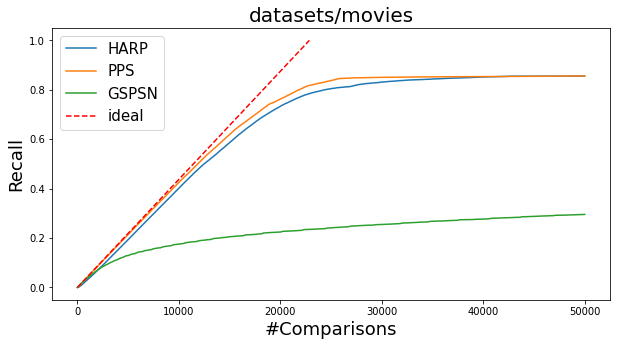

time: 228 ms (started: 2021-12-07 14:06:59 +00:00)


In [30]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax.set_title(dataset, fontsize=20)
ax.set_xlabel('#Comparisons', fontsize=18)
ax.set_ylabel('Recall', fontsize=18)
plt.plot(p_rec[0:n], label="HARP")
plt.plot(pps_rec[0:n], label="PPS")
plt.plot(gp_rec[0:n], label="GSPSN")
plt.plot([0, len(new_gt)], [0, 1], 'r--', label="ideal")
plt.legend(fontsize=15)
plt.show()